# Temperature prediction using Time Series Analyses

## Goals



In this project, you will create a short-term temperature forecast.

- Get and clean temperature data from www.ecad.eu

- Build a baseline model modelling trend and seasonality

- Plot and inspect the different components of a time series

- Model time dependence of the remainder using an AR model

- Compare the statistical output of different AR models

- Test the remainder for stationarity

- upload your code to GitHub



In [36]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline



from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


from sklearn.metrics import mean_absolute_error


In [18]:
# read data

temp = pd.read_table("../00_data/ECA_blended_custom/TG_STAID002759.txt",
na_values=-9999, skiprows=19,skipinitialspace=True, delimiter=',', parse_dates=[1])
print(temp.columns)
temp[["TG"]] = temp[["TG"]] / 10

temp.head()

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')


,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,2.2,0
1,127488,1876-01-02,2.5,0
2,127488,1876-01-03,0.3,0
3,127488,1876-01-04,-5.8,0
4,127488,1876-01-05,-9.8,0


<AxesSubplot:ylabel='DATE'>

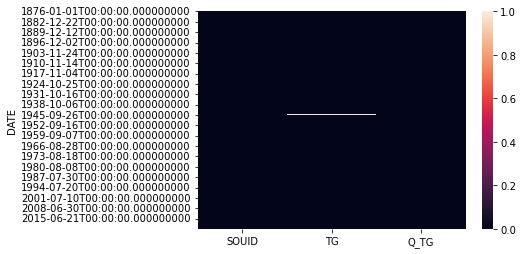

In [39]:
sns.heatmap(temp.set_index('DATE').isna())

In [19]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53477 entries, 0 to 53476
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   SOUID   53477 non-null  int64         
 1   DATE    53477 non-null  datetime64[ns]
 2   TG      53282 non-null  float64       
 3   Q_TG    53477 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.6 MB


In [42]:
temp = temp.loc[temp.DATE > "1949-12-31", ]

In [24]:
86400000000000/3600*24

576000000000.0

## Generate Stationary series

### Add time features

In [44]:
# make function that cycles through time attrs and then adds a column to the df

def make_time_cols(time_att, time_series):
    
    feature_list = []

    for ta in time_att:
        try:

            dtobj = getattr(time_series, 'dt')

            feature_list.append(pd.Series(getattr(dtobj,ta), name = ta))
        except AttributeError:
            print(f'Time Attribute not present: {ta}')

    return pd.concat(feature_list, axis = 1)

In [45]:
X = temp[["DATE"]]
y = temp["TG"]
time_atts = make_time_cols(time_att= ['year', 'month', 'week', 'dayofyear'], time_series = X.DATE)

X = pd.concat([X, time_atts], axis = 1)


/tmp/ipykernel_447038/1725717165.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  feature_list.append(pd.Series(getattr(dtobj,ta), name = ta))


In [94]:
X

,DATE,year,month,week,dayofyear
0,1876-01-01,1876,1,52,1
1,1876-01-02,1876,1,52,2
2,1876-01-03,1876,1,1,3
3,1876-01-04,1876,1,1,4
4,1876-01-05,1876,1,1,5
...,...,...,...,...,...
53472,2022-05-27,2022,5,21,147
53473,2022-05-28,2022,5,21,148
53474,2022-05-29,2022,5,21,149
53475,2022-05-30,2022,5,22,150


In [46]:
X.describe()

,year,month,week,dayofyear
count,26449.000000,26449.000000,26449.000000,26449.000000
mean,1985.708722,6.502892,26.505652,182.513668
std,20.905239,3.450738,15.072738,105.499992
min,1950.000000,1.000000,1.000000,1.000000
25%,1968.000000,4.000000,13.000000,91.000000
50%,1986.000000,7.000000,26.000000,182.000000
75%,2004.000000,10.000000,40.000000,274.000000
max,2022.000000,12.000000,53.000000,366.000000


## Model Trend and Seasonality


In [47]:
trans = ColumnTransformer([
    ('linear', 'passthrough', ['year']),
    ('oh', OneHotEncoder(drop='first', sparse=True), ['week'])

],
    remainder = 'drop')

detrend = Pipeline([
    ('transform', trans),
    ('model', LinearRegression())
])

detrend.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('linear', 'passthrough',
                                                  ['year']),
                                                 ('oh',
                                                  OneHotEncoder(drop='first'),
                                                  ['week'])])),
                ('model', LinearRegression())])

Remove trend and seasonality:

In [48]:
y_detrend = y - detrend.predict(X)

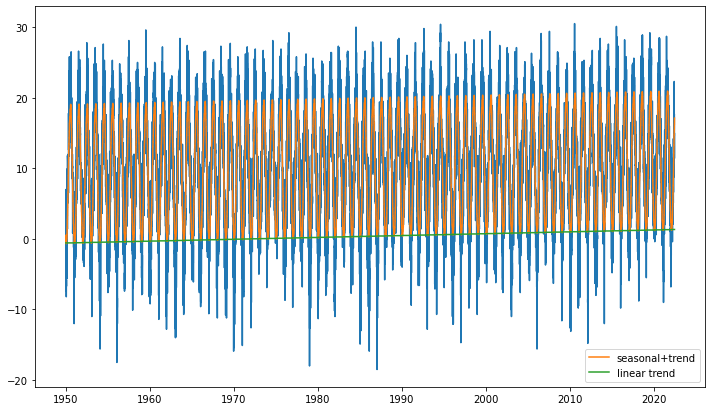

In [51]:
plt.rcParams['figure.figsize'] = (12,7)

t_subs = 365 * 130

plt.plot(X['DATE'][-t_subs:], y[-t_subs:])
plt.plot(X['DATE'][-t_subs:], detrend.predict(X)[-t_subs:], label = 'seasonal+trend')
plt.plot(X['DATE'][-t_subs:], X['year'][-t_subs:] * detrend.named_steps['model'].coef_[0] + detrend.named_steps['model'].intercept_, label = 'linear trend')
plt.legend()

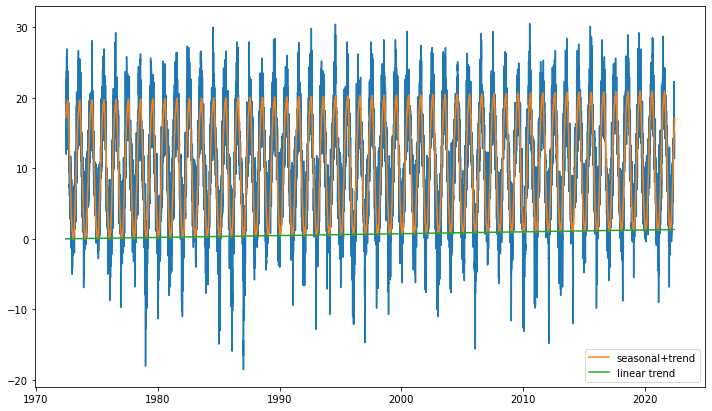

In [52]:
plt.rcParams['figure.figsize'] = (12,7)

t_subs = 365 * 50

plt.plot(X['DATE'][-t_subs:], y[-t_subs:])
plt.plot(X['DATE'][-t_subs:], detrend.predict(X)[-t_subs:], label = 'seasonal+trend')
plt.plot(X['DATE'][-t_subs:], X['year'][-t_subs:] * detrend.named_steps['model'].coef_[0] + detrend.named_steps['model'].intercept_, label = 'linear trend')
plt.legend()

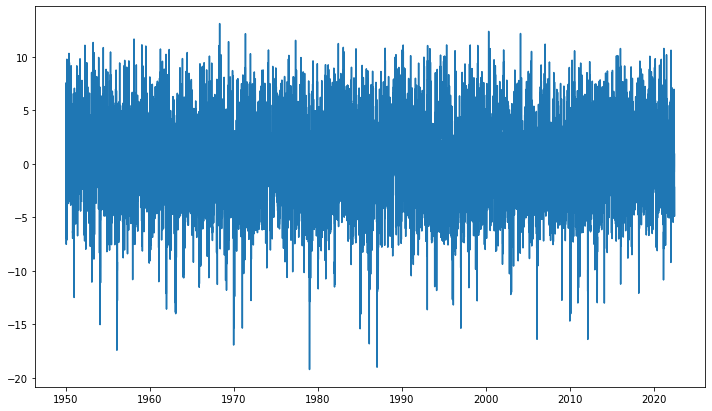

In [53]:
plt.plot(X['DATE'], y_detrend)

## Identify AR / MA orders

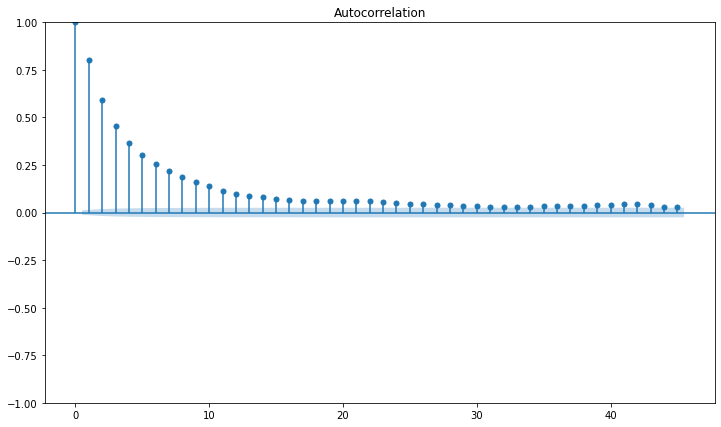

In [54]:
plot = plot_acf(y_detrend)

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


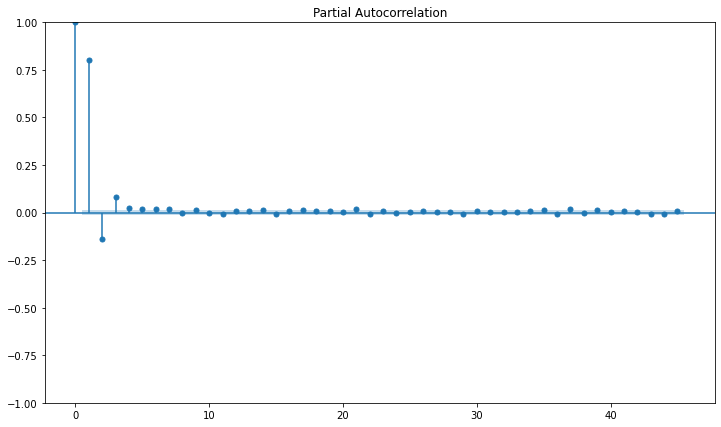

In [56]:
plot = plot_pacf(y_detrend)

Asessment: 

P = 1  
Q = 3

## Generate ARIMA(3,0,1)

In [57]:
from statsmodels.tsa.arima.model import ARIMA

In [58]:
arima = ARIMA(endog= y_detrend, order = (3,0,1)).fit()

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [60]:
y_arima = arima.predict()

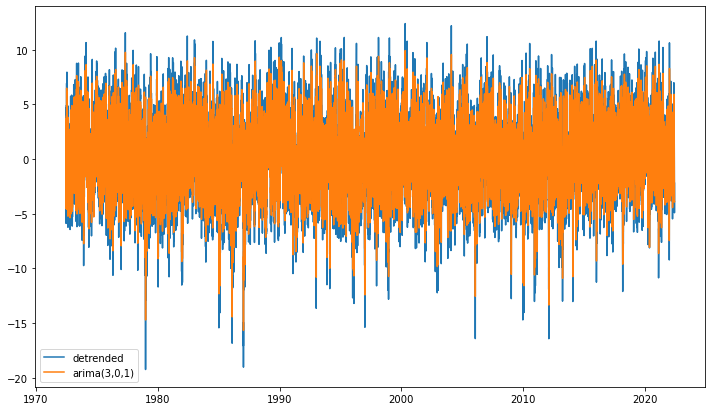

In [61]:
plt.plot(X['DATE'][-t_subs:], y_detrend[-t_subs:], label = 'detrended')
plt.plot(X['DATE'][-t_subs:], y_arima[-t_subs:], label = 'arima(3,0,1)')
plt.legend()

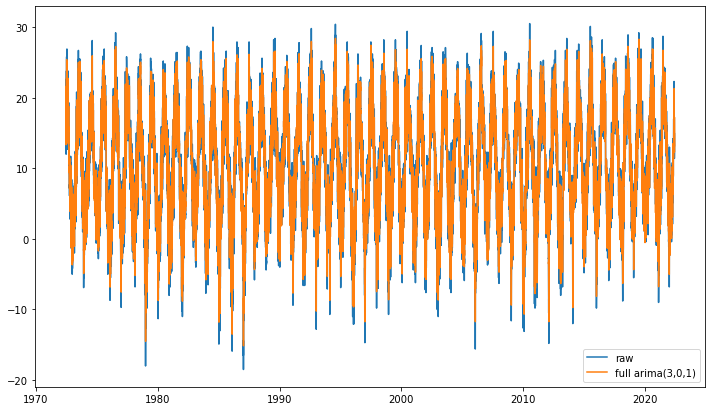

In [62]:
plt.plot(X['DATE'][-t_subs:], y[-t_subs:], label = 'raw')
plt.plot(X['DATE'][-t_subs:], y_arima[-t_subs:] + detrend.predict(X)[-t_subs:], label = 'full arima(3,0,1)')
plt.legend()

## Evaluate

In [64]:
temp_mae = mean_absolute_error(y, y_arima + detrend.predict(X))

print(f"The ARIMA(3,0,1) temperature prediction is on average off by {round(temp_mae,2)} \u2103 for any given day.")


The ARIMA(3,0,1) temperature prediction is on average off by 1.75 ℃ for any given day.


## Compare different ARIMA models

- generate grid $q = [1:3],~p = [1:3]$
- run ARIMA with $q_i$, $p_i$ on detrended
- calculate MAE

In [226]:
import itertools
def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())



arima_grid = expand_grid(
    {
        'p' : [0,1,2,3,4,5,6],
        'q' : [0,1,2,3,4,5,6]
    
    }
)
print(arima_grid)

    p  q
0   0  0
1   0  1
2   0  2
3   0  3
4   0  4
5   0  5
6   0  6
7   1  0
8   1  1
9   1  2
10  1  3
11  1  4
12  1  5
13  1  6
14  2  0
15  2  1
16  2  2
17  2  3
18  2  4
19  2  5
20  2  6
21  3  0
22  3  1
23  3  2
24  3  3
25  3  4
26  3  5
27  3  6
28  4  0
29  4  1
30  4  2
31  4  3
32  4  4
33  4  5
34  4  6
35  5  0
36  5  1
37  5  2
38  5  3
39  5  4
40  5  5
41  5  6
42  6  0
43  6  1
44  6  2
45  6  3
46  6  4
47  6  5
48  6  6


### Cross Validation and Grid Search




In [227]:
from sklearn.model_selection import TimeSeriesSplit

In [228]:
ts_split = TimeSeriesSplit(n_splits=3)

In [229]:
for index, (train_index, val_index) in enumerate(ts_split.split(y_detrend)):
    print(f'Iteration: {index}.  train obs: {train_index[0]} to {train_index[-1]}')
    print(f'Iteration: {index}. validation obs: {val_index[0]} to {val_index[-1]}')
    print()

Iteration: 0.  train obs: 0 to 6612
Iteration: 0. validation obs: 6613 to 13224

Iteration: 1.  train obs: 0 to 13224
Iteration: 1. validation obs: 13225 to 19836

Iteration: 2.  train obs: 0 to 19836
Iteration: 2. validation obs: 19837 to 26448



In [230]:
y_detrend.index = temp['DATE']

In [231]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [232]:
def arima_crossval(detrended, arima_params, splits = 3):

    param_list = [None] * len(arima_params)
    mae_list = [None] * len(arima_params)
    mae_av = [None] * len(arima_params)
    

    ts_split = TimeSeriesSplit(n_splits=splits)

    for idx in range(len(arima_params)):
        dfsplits = ts_split.split(detrended)

        p = arima_params['p'].iloc[idx]
        q = arima_params['q'].iloc[idx]

        print(f'p is {p} and q is {q}')




        mae_fold_list = [None] * splits

        print(len(mae_fold_list))

        for tsidx, (train_index, test_index) in enumerate(dfsplits):


            
            arima_train = SARIMAX(endog= detrended.iloc[train_index], order = (p,0,q), freq='D', disp = False).fit(disp = False)
            y_test = arima_train.predict(detrended.index[test_index][0],detrended.index[test_index][-1],freq='D')
            mae_test = mean_absolute_error(detrended.iloc[test_index], y_test)



            mae_fold_list[tsidx] = mae_test

        print(mae_fold_list)
        param_list[idx] = arima_params.iloc[idx]
        mae_list[idx] = mae_fold_list
        mae_av[idx] = np.average(mae_fold_list)

        print('end loop')



    results = {
        'parameters' : pd.concat([pd.DataFrame(v).T for v in param_list]),
        'mae_runs' : pd.concat([pd.DataFrame(v).T for v in mae_list]),
        'mae_avs' : pd.DataFrame({'mae_av' : mae_av})
    }

    return results


        


In [ ]:

model_res = arima_crossval(detrended = y_detrend, arima_params = arima_grid, splits = 3)



In [240]:
res_df = pd.concat([v.reset_index().drop('index', axis = 1) for k,v in model_res.items()], axis = 1)
res_df.head()

,p,q,0,1,2,mae_av
0,0,0,3.057266,3.113461,2.934055,3.034927
1,0,1,3.057356,3.113460,2.933734,3.034850
2,0,2,3.057476,3.113337,2.933710,3.034841
3,0,3,3.057507,3.113217,2.933650,3.034791
4,0,4,3.057507,3.113305,2.933557,3.034790


In [239]:
res_df.sort_values('mae_av').head(3)

,p,q,0,1,2,mae_av
40,5,5,3.057160,3.111625,2.933730,3.034171
33,4,5,3.057171,3.111704,2.933731,3.034202
37,5,2,3.057173,3.111885,2.933614,3.034224


## Sktime Forecast

In [49]:
from statsmodels.tsa.tsatools import lagmat 

lagmat(y, maxlag = 3)

array([[ 0. ,  0. ,  0. ],
       [ 2.2,  0. ,  0. ],
       [ 2.5,  2.2,  0. ],
       ...,
       [11.4, 14. , 17.2],
       [12. , 11.4, 14. ],
       [12.2, 12. , 11.4]])